# 0. First steps



## 0.1. Imports

In [ ]:
##Opening Data And saving

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.

drive.mount('/content/drive/')
data_path = '/content/drive/Shareddrives/IR'
output_path = '/content/drive/Shareddrives/IR/outputs/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install config

In [ ]:
!pip install gensim


In [ ]:
from google.colab import files
uploaded = files.upload()
for file in uploaded:
  print("file name : {} , length: {}".format(file,len(file)))


Saving myfunctions.py to myfunctions.py
file name : myfunctions.py , length: 14


In [ ]:
from myfunctions import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Developer Twitter Account

In [ ]:
# download tweepy
#!pip install tweepy
## access token informations 
access_token1 = "1332632576410968064-gc9op6TEiTZuIW5bJiWaEB1owOM5jK"
access_token_secret1 = "wwrVbOp6x1F8FKUgtUKPIcHcHildRhtOCLAl5uaNNZYEc"

consumer_key1 = "c6jdXukqsxOSd7c8RHqRwQFvP"
consumer_secret1 = "8qj5TbLB9iW4s4hKfHCjCEDSiyHhDfbvd2jb7uCGnIRxUnDBIY"

In [ ]:
#Import the necessary methods from tweepy library
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
import json
import datetime



In [ ]:
auth = OAuthHandler(consumer_key1, consumer_secret1)
auth.set_access_token(access_token1, access_token_secret1)
api = API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# 1. Scraping Twitter Data


THERE IS NO NEED TO RUN THIS, AS WE PROVIDE THE FILE WITH THE SCRAPPED TWEETS

## Streaming API

The Twitter API allows you to collect the public stream of Tweets, filtering them by topic. To do so, we need to set a "Listener", through Tweepy, in order to set some parameters like how much tweets to collect, how to store them, how to handle errors, etc... 

In [ ]:
class MyStreamListener(StreamListener):
    """
    Twitter listener, collects streaming tweets and output to a file
    """
    def __init__(self, api, OUTPUT_FILENAME, stop_condition=10):
        """
        initialize the stream, with num. of tweets and saving the outputfile
        """
        
        # this line is needed to import the characteristics of the streaming API
        super(MyStreamListener, self).__init__()
        
        # to-count the number of tweets collected        
        self.num_tweets = 0
        
        # save filename
        self.filename = OUTPUT_FILENAME
        
        # stop-condition
        self.stop_condition = stop_condition
        

    def on_status(self, status):
        
        """
        this function runs each time a new bunch of tweets is retrived from the streaming
        """
        with open(self.filename, "a+") as f:
            tweet = status._json
            
            f.write(json.dumps(tweet) + '\n')
            #self.output.append(tweet)
            self.num_tweets += 1
        
            # Stop condition        
            if self.num_tweets <= self.stop_condition:
                return True
            else:
                return False

        #Favourite_count different from 0 
        if status.favorite_count > 0:
          return True
        else: 
          return False
          

    def on_error(self, status):
        """
        function useful to handle errors. It's possible to personalize it 
        depending on the way we want to handle errors
        """
        
        print(status)
        #returning False in on_error disconnects the stream
        return False

Here we download a bunch of tweets with a set of keywords related to covid ```["coronavirus", "covid"]```

In [ ]:
OUTPUT_FILENAME = "/data/one.json"
if os.path.exists(data_path+OUTPUT_FILENAME):
  os.remove(data_path+OUTPUT_FILENAME)

In [ ]:
%%time
OUTPUT_FILENAME = "/data/one.json"
stop_condition = 150000

l = MyStreamListener(api, data_path + OUTPUT_FILENAME, stop_condition)
# here we recall the Stream Class from Tweepy to input the authentication info and our personalized listener 
stream = Stream(auth=api.auth, listener=l)


# keywords we may want decide to track 
TRACKING_KEYWORDS = ["coronavirus", "covid", "#COVID", "#coronavirus", "#COVID19", "Wuhan", "lockdown", "mask", "deaths", "pandemic", "cough", 
                     "hospital collapse", "vaccine", "immunity"]
stream.filter(
    track=TRACKING_KEYWORDS, 
    async=False, 
    languages = ["en"]
)

CPU times: user 2min 49s, sys: 42.5 s, total: 3min 31s
Wall time: 51min 36s


#2. Data collection

In [ ]:
 OUTPUT_FILENAME = "/data/tweets100_hydrated.json"
 with open(data_path+OUTPUT_FILENAME, 'r') as f:
    lines = f.readlines() # read lines
    data = [json.loads(str_) for str_ in lines]

In [ ]:
f.close()

In [ ]:
df_tweets = pd.DataFrame.from_records(data)
df_tweets["retweeted_status"]=df_tweets["retweeted_status"].apply(lambda x: 0 if str(x)=="nan" else x)

#0: tweets are not RT
#1: tweets are RT

#Take only non-RT tweets: df_original
df_original = df_tweets[df_tweets["retweeted_status"]==0]
df_original

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,possibly_sensitive,extended_entities,withheld_in_countries
1,Thu Dec 17 13:47:46 +0000 2020,1339567967223250947,1339567967223250947,Oh yr eh ohi nhi aa jine corona kr k parliamen...,False,"[0, 157]","{'hashtags': [{'text': 'FarmersProtest', 'indi...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 863024748590059521, 'id_str': '86302474...",None,None,None,None,0,True,1,7,False,False,en,1.339402e+18,1339402143866912770,"{'url': 'https://t.co/S8foPwBiKY', 'expanded':...",{'created_at': 'Thu Dec 17 02:48:50 +0000 2020...,False,NaN,NaN
4,Thu Dec 17 13:47:46 +0000 2020,1339567967613366272,1339567967613366272,@sambosnumerouno @MENnewsdesk @ccoxmenmedia Ye...,False,"[44, 322]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",1.339567e+18,1339566783964045312,9.286508e+17,928650799349161984,sambosnumerouno,"{'id': 2831341487, 'id_str': '2831341487', 'na...",None,None,None,None,0,False,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Thu Dec 17 13:47:46 +0000 2020,1339567967680475136,1339567967680475136,How about not acknowledging Covid\nThe dangers...,False,"[0, 196]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,None,NaN,None,None,"{'id': 802581205262696448, 'id_str': '80258120...",None,None,None,None,0,True,0,0,False,False,en,1.339376e+18,1339375759677411328,"{'url': 'https://t.co/ukUd8G4XQP', 'expanded':...",{'created_at': 'Thu Dec 17 01:04:00 +0000 2020...,False,NaN,NaN
8,Thu Dec 17 13:47:46 +0000 2020,1339567967718305794,1339567967718305794,fuck we really boutta be 5-9 😔 https://t.co/h8...,False,"[0, 30]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 1037829476267249664, 'id_str': '1037829...",None,None,None,None,0,True,0,1,False,False,en,1.339568e+18,1339567549768491012,"{'url': 'https://t.co/h8gTqdoBfm', 'expanded':...",{'created_at': 'Thu Dec 17 13:46:06 +0000 2020...,False,NaN,NaN
11,Thu Dec 17 13:47:46 +0000 2020,1339567968234201093,1339567968234201093,oh no 😂 https://t.co/op7jImeDRi,False,"[0, 7]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 1313181832700194818, 'id_str': '1313181...",None,None,None,None,0,True,0,0,False,False,en,1.339568e+18,1339567549768491012,"{'url': 'https://t.co/op7jImeDRi', 'expanded':...",{'created_at': 'Thu Dec 17 13:46:06 +0000 2020...,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146285,Thu Dec 17 14:39:21 +0000 2020,1339580950418624517,1339580950418624517,@Morning_Joe @kasie That’s pathetic honestly h...,False,"[20, 297]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",1.339541e+18,1339540962951852034,2.541174e+08,254117355,Morning_Joe,"{'id': 1198836763436994560, 'id_str': '1198836...",None,None,None,None,0,False,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146288,Thu Dec 17 14:39:21 +0000 2020,1339580950502658049,1339580950502658049,@EricLiptonNYT Guess again! \n\nhttps://t.co/a...,False,"[15, 53]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.339579e+18,1339578713076326411,3.756626e+08,375662595,EricLiptonNYT,"{'id': 1154433747141480448, 'id_str': '1154433...",None,None,None,None,0,False,0,0,False,False,en,NaN,NaN,NaN,NaN,False,NaN,NaN
146290,Thu Dec 1

## 0. Preprocessing tweets

## Preprocessing tweets

The preprocessing process is included in preprocess.py library.

## A. Data structure

In [ ]:
def print_retweets_uniqueTweets_uniqueUsers(df_tweets):
    tweets_ = df_tweets["retweeted_status"].apply(lambda x: 0 if str(x) == "nan" else 1)
    #0 if not retweeted
    tot_retweets = sum(tweets_)

    original_ = df_tweets[df_tweets["retweeted_status"]==0]
    tot_originals = len(original_)

    users_ = df_tweets.user.apply(lambda x: x['id'] )
    
    tot_users = len(set(users_))
    
    print("Total Tweets")
    print(tot_retweets)

    print("Total Tweets")
    print(tot_originals)

    print("Unique Users")
    print(tot_users)

In [ ]:
print_retweets_uniqueTweets_uniqueUsers(df_tweets)

Total Tweets
146305
Total Tweets
46580
Unique Users
105491


Now we will focus on the statistics of our dataset df_orignal (non-retweeted tweets), which is the one we will use to create our Search Engine.

In [ ]:
def extract_hashtags():
    hashtags_lists = df_original["entities"].apply(lambda x: x['hashtags'])
    
    hashtags = hashtags_lists.apply(lambda x: x[0]["text"].lower() if x!= [] else None)
    
    hashtags_by_frequency = Counter(hashtags)
    hashtags_by_frequency = {k: hashtags_by_frequency[k] for k in hashtags_by_frequency if k != None} 
    
    return hashtags_by_frequency

In [ ]:
hashtags_by_frequency = extract_hashtags()

Let's plot the top-5 frequent hashtags now

In [ ]:
df_hashtags = pd.DataFrame(hashtags_by_frequency.items())
df_hashtags.columns = ["hashtag", "count"]
df_hashtags.set_index("hashtag", inplace=True)
df_hashtags.sort_values("count", inplace=True, ascending=False)

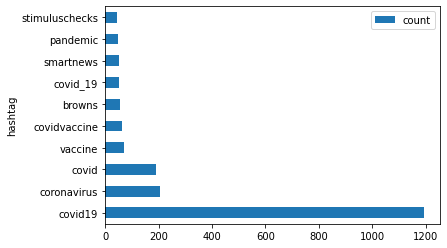

In [ ]:
df_hashtags.head(10).plot.barh()
plt.show()

Let's try now to generate a wordcloud given the tweets we have collected.

## B. Wordcloud

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import re

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words("english"))

In [ ]:
bag_of_words = {}
for text in df_original["full_text"]:
  
    lst_text = preprocess_tweet(text)    
    
    # create bag-of-words - for each word the frequency of the word in the corpus
    for w in lst_text:
      if w not in bag_of_words:
        bag_of_words[w] = 0
      bag_of_words[w] +=1

Also, we will plot the 10 most repeated words in our tweets collection.

In [ ]:
most_used_words = dict(sorted(bag_of_words.items(), key=lambda item: item[1], reverse=True))

In [ ]:
df_words = pd.DataFrame(most_used_words.items())
df_words.columns = ["word", "count"]
df_words.set_index("word", inplace=True)
df_words.sort_values("count", inplace=True, ascending=False)

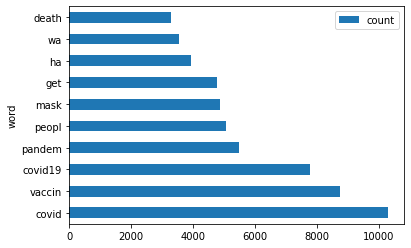

In [ ]:
df_words.head(10).plot.barh()
plt.show()

In [ ]:
def plot_wordcloud(title, dic_):
    fig, ax = plt.subplots(1, 1, figsize=(18,7))
    wordcloud = WordCloud(background_color="white",width=1600, height=800)
    wordcloud = wordcloud.generate_from_frequencies(dic_)
    ax.axis("off")     
    ax.imshow(wordcloud, interpolation='bilinear')

    ax.set_title(title)
    plt.tight_layout()
    fig.subplots_adjust(top=0.8)
    plt.show()

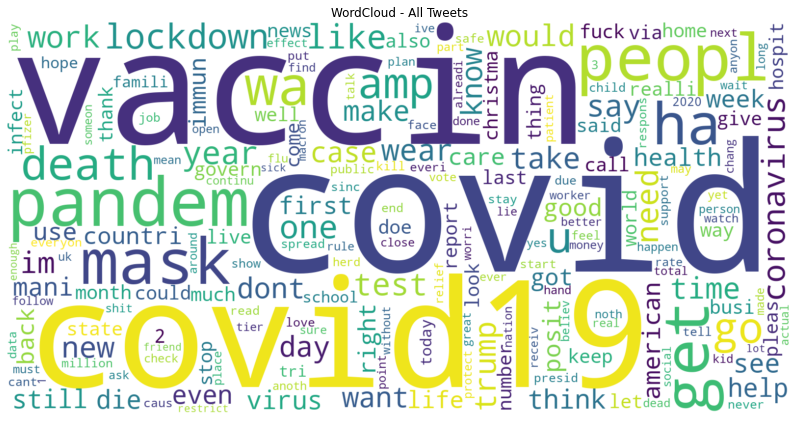

In [ ]:
plot_wordcloud("WordCloud - All Tweets", bag_of_words)

# 3. Inverted index

This section is repeated for RQ1(word2vec is directly there and in myfunctions.py)



##TF-IDF index

Created thanks to functions provided in library myfunctions.py

In [ ]:
start_time = time.time()
numDocuments = len(df_original)
index, tf, df, idf = create_index_tfidf(df_original, numDocuments)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time,2)))

Total time to create the index: 163.9 seconds


In [ ]:
def search_tf_idf(query, index,df):
    '''
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    '''

    query=preprocess_tweet(query)
    docs=set()
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]
            
            # docs = docs Union termDocs
            docs |= set(termDocs)
        except:
            #term is not in index
            pass


    ranked_docs = rankDocuments(query, docs, index, idf, tf) 

    docs=list(ranked_docs)
    output = []


    for i in docs:
      hashtag = []
      if df.loc[i]["entities"]["hashtags"]:
        for k in range(len(df.loc[i]["entities"]["hashtags"])):
          hashtag.append(df.loc[i]["entities"]["hashtags"][k]["text"])
      else:
        hashtag.append("No Hashtags")

      text = regex.sub('@[^\s]+', '', df.loc[i]["full_text"])
      text = regex.sub(r'http\S+', '', text)

    
      output.append([i,text, df.loc[i]["user"]["screen_name"], df.loc[i]["created_at"], hashtag, df.loc[i]["favorite_count"], df.loc[i]["retweet_count"],regex.findall('http\S+', df.loc[i]["full_text"])])

    
    
    return output


In [ ]:
print("Insert your query:\n")
query = input()
ranked_docs = search_tf_idf(query, index,df_original)    
top = 10


Insert your query:

Obama


In [ ]:
df_Ranking = pd.DataFrame(ranked_docs[:top], columns = ["ID", "Tweet", "Username", "Date", "Hashtags", "Likes", "Retweets", "URL"])

df_Ranking

,ID,Tweet,Username,Date,Hashtags,Likes,Retweets,URL
0,40210,Now do Reagan through Obama.,J_Dubya80,Thu Dec 17 14:01:56 +0000 2020,[No Hashtags],0,0,[https://t.co/QEd7LnMW3E]
1,16244,Why would Trump trust Obama’s pandemic t...,FightandDebate,Thu Dec 17 13:53:28 +0000 2020,[No Hashtags],0,0,[]
2,17546,But Obama wore a tan suit?,ssurovell,Thu Dec 17 13:53:57 +0000 2020,[No Hashtags],52,7,[https://t.co/wr6XbZvQXt]
3,74624,Corona virus vaccine research was started an...,EntropyJimJohn,Thu Dec 17 14:14:07 +0000 2020,[No Hashtags],0,0,[]
4,70590,GOP congressman who once shouted ‘you lie’ dur...,thomaskaine5,Thu Dec 17 14:12:41 +0000 2020,[No Hashtags],85,27,[https://t.co/2HVGDpakUR]
5,47131,GOP congressman who once shouted ‘you lie’ dur...,santo_aol,Thu Dec 17 14:04:24 +0000 2020,[No Hashtags],1,0,[https://t.co/u60Y6YhDQ3]
6,94966,Biden worked as VP under Obama and handle...,Cece57938158,Thu Dec 17 14:21:17 +0000 2020,[No Hashtags],0,0,[]
7,89558,Has Obama taken the vaccine? I’ll take it if B...,Chels_Ayyeee,Thu Dec 17 14:19:23 +0000 2020,[No Hashtags],0,0,[]
8,127108,Was just looking to see whether Obama pardo...,Playerinthgame,Thu Dec 17 14:32:36 +0000 2020,[No Hashtags],2,0,[]
9,134117,These Trumpublkkkans would be the ones fi...,JonathanTrubow,Thu Dec 17 14:35:05 +0000 2020,[No Hashtags],2,0,[]


In [ ]:
df_Ranking.to_csv(output_path+"df_Ranking.csv", sep =";")

## OUR RANKING

In [ ]:
def search_tf_idf_YOURSCORE(query, index,df):
    '''
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    '''

    query=preprocess_tweet(query)
    docs=set()
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]
            
            # docs = docs Union termDocs
            docs |= set(termDocs)
        except:
            #term is not in index
            pass


    ranked_docs = rankDocuments(query, docs, index, idf, tf) 
 
    rankingDataFrame = pd.DataFrame(columns = df.columns.values)

    print(ranked_docs)

    for i in ranked_docs:
      rankingDataFrame = rankingDataFrame.append(df.loc[i])
    
    rankingDataFrame.head()
    rankingDataFrame = rankingDataFrame.sort_values(by='favorite_count', ascending=False)

    orderedDocs = rankingDataFrame.index

    #docs=list(ranked_docs)
    output = []


    for i in orderedDocs:
      hashtag = []
      if df.loc[i]["entities"]["hashtags"]:
        for k in range(len(df.loc[i]["entities"]["hashtags"])):
          hashtag.append(df.loc[i]["entities"]["hashtags"][k]["text"])
      else:
        hashtag.append("No Hashtags")

      text = regex.sub('@[^\s]+', '', df.loc[i]["full_text"])
      text = regex.sub(r'http\S+', '', text)

    
      output.append([i,text, df.loc[i]["user"]["screen_name"], df.loc[i]["created_at"], hashtag, df.loc[i]["favorite_count"], df.loc[i]["retweet_count"],regex.findall('http\S+', df.loc[i]["full_text"])])

    
    
    return output

In [ ]:
print("Insert your query:\n")
query = input()
ranked_docs = search_tf_idf_YOURSCORE(query, index,df_original)    
top = 10



Insert your query:

Obama
[40210, 16244, 17546, 74624, 70590, 47131, 94966, 89558, 127108, 134117, 66049, 141282, 76110, 59649, 33087, 113814, 11634, 13943, 64186, 5974, 98322, 44364, 35198, 51935, 9031, 130531, 67737, 12051, 7840, 6164, 19741, 113773, 36689, 7908, 137237, 57206, 117490, 110260, 84921, 104318, 86151, 62094, 34783, 7778, 1225, 27659, 128836, 54051, 796, 66848, 84939, 102075, 113559, 109145, 57353, 73924, 42703, 125380, 10963]
Int64Index([104318,  70590,  17546,  19741,  62094,  13943,  59649,  73924,
            127108, 134117,  57353,  67737,  57206,  36689,  34783,  27659,
            117490,  47131,  66848, 109145, 125380, 110260,  84921,  42703,
             86151, 113559,    796, 102075,   7778,   1225,  84939, 128836,
             54051,  40210,   6164, 137237,   7908,  74624,  94966,  89558,
             66049, 141282,  76110,  33087, 113814,  11634,  64186,   5974,
             98322,  44364,  35198,  51935,   9031, 130531,  12051,   7840,
             16244, 11

In [ ]:
df_ourRanking = pd.DataFrame(ranked_docs[:top], columns = ["ID", "Tweet", "Username", "Date", "Hashtags", "Likes", "Retweets", "URL"])

df_ourRanking

,ID,Tweet,Username,Date,Hashtags,Likes,Retweets,URL
0,104318,Forgive me for not wanting Michelle Obama - w...,mehdirhasan,Thu Dec 17 14:24:35 +0000 2020,[No Hashtags],106,10,[https://t.co/Mj7CVxRV0R]
1,70590,GOP congressman who once shouted ‘you lie’ dur...,thomaskaine5,Thu Dec 17 14:12:41 +0000 2020,[No Hashtags],85,27,[https://t.co/2HVGDpakUR]
2,17546,But Obama wore a tan suit?,ssurovell,Thu Dec 17 13:53:57 +0000 2020,[No Hashtags],52,7,[https://t.co/wr6XbZvQXt]
3,19741,Imagine thinking of cutting healthcare fundin...,foseeorara,Thu Dec 17 13:54:43 +0000 2020,[No Hashtags],21,0,[]
4,62094,You must have also missed Hillary Clinton’s ...,JDworetzky,Thu Dec 17 14:09:41 +0000 2020,[No Hashtags],11,3,[]
5,13943,You don't want to know what my thoughts are co...,davida76321,Thu Dec 17 13:52:40 +0000 2020,[No Hashtags],6,2,[https://t.co/jkYAmym7tx]
6,59649,I thought Biden and Obama were supposed to be ...,thesarah_o,Thu Dec 17 14:08:50 +0000 2020,[No Hashtags],6,0,[https://t.co/VGhNZtXL7G]
7,73924,Obama got the Nobel Peace Award for nothing\n...,Filamleis,Thu Dec 17 14:13:52 +0000 2020,[No Hashtags],2,1,[]
8,127108,Was just looking to see whether Obama pardo...,Playerinthgame,Thu Dec 17 14:32:36 +0000 2020,[No Hashtags],2,0,[]
9,134117,These Trumpublkkkans would be the ones fi...,JonathanTrubow,Thu Dec 17 14:35:05 +0000 2020,[No Hashtags],2,0,[]


In [ ]:
df_ourRanking.to_csv(output_path+"df_ourRanking.csv", sep =";")